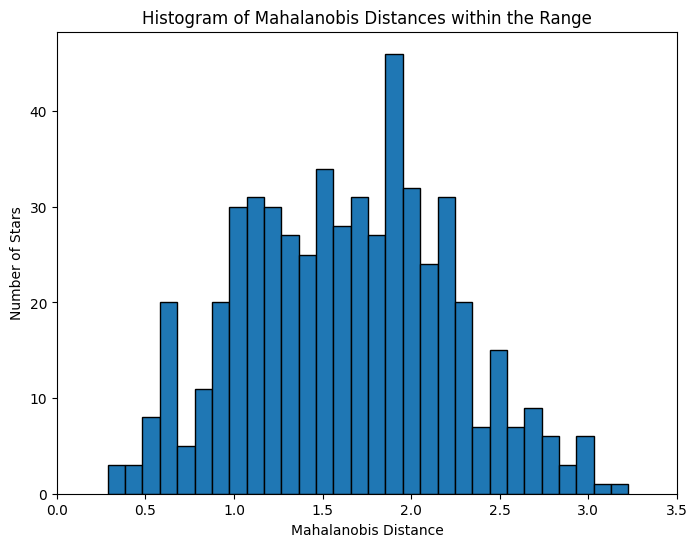

C:\Users\Albert1879\AppData\Local\Temp\ipykernel_8424\1198066560.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mahalanobis Distance'] = mahalanobis_distances


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(r'E:\dissertation\M21\M21(20).csv')

# Define a function to calculate Mahalanobis distances
def calculate_mahalanobis_distances(data, parallax_range, pmra_range, pmdec_range):
    df = data[(data['parallax'] >= parallax_range[0]) & (data['parallax'] <= parallax_range[1]) &
              (data['pmra'] >= pmra_range[0]) & (data['pmra'] <= pmra_range[1]) &
              (data['pmdec'] >= pmdec_range[0]) & (data['pmdec'] <= pmdec_range[1])]
    X = df[['parallax', 'pmra', 'pmdec']].values
    mean = np.mean(X, axis=0)
    covariance = np.cov(X, rowvar=False)
    mahalanobis_distances = []
    for x in X:
        mahalanobis_distances.append(np.sqrt(np.dot(np.dot((x - mean), np.linalg.inv(covariance)), (x - mean).T)))
    return mahalanobis_distances, df

# Define ranges to try
parallax_range = (0.66, 0.86)
pmra_range = (-0.3, 1)
pmdec_range = (-1.8, -1.2)

# Calculate Mahalanobis distances for the specified ranges
mahalanobis_distances, df = calculate_mahalanobis_distances(data, parallax_range, pmra_range, pmdec_range)

# Plot the histogram of Mahalanobis distances
plt.figure(figsize=(8, 6))
plt.hist(mahalanobis_distances, bins=30, edgecolor='black')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Stars')
plt.xlim(0, 3.5)
plt.ylim(0, plt.ylim()[1])  # Set y-axis to start at 0
plt.title('Histogram of Mahalanobis Distances within the Range')
plt.show()

# Add the Mahalanobis distances to the DataFrame
df['Mahalanobis Distance'] = mahalanobis_distances

In [85]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture

def gaussian(x, mean, covariance):
    return np.exp(-((x - mean) ** 2) / (2 * covariance)) / np.sqrt(2 * np.pi * covariance)

def fit_gmm(data, n_components=2, max_iter=2000, tol=1e-14):
    n_samples = len(data)
    # Initialize mean and covariance randomly
    mean = np.random.choice(data, size=n_components)
    covariance = [np.cov(data, rowvar=False)] * n_components
    weights = [1 / n_components] * n_components
    
    for _ in range(max_iter):
        # E-step
        responsibility = np.zeros((n_samples, n_components))
        for i in range(n_samples):
            for j in range(n_components):
                responsibility[i, j] = weights[j] * gaussian(data[i], mean[j], covariance[j])
        responsibility /= np.sum(responsibility, axis=1, keepdims=True)
        

        # M-step
        prev_mean = mean.copy()
        prev_covariance = covariance.copy()
        prev_weights = weights.copy()
        for j in range(n_components):
            mean[j] = np.sum(responsibility[:, j] * data) / np.sum(responsibility[:, j])
            covariance[j] = np.sum(responsibility[:, j] * (data - mean[j]) ** 2) / np.sum(responsibility[:, j])
            weights[j] = np.sum(responsibility[:, j]) / n_samples

        # Check for convergence
        if np.allclose(prev_mean, mean, atol=tol) and np.allclose(prev_covariance, covariance, atol=tol) and np.allclose(prev_weights, weights, atol=tol):
            break

    return mean, covariance, weights, responsibility


weights, mean, covariance, responsibility= fit_gmm(mahalanobis_distances)

membership_pob = 0.5
cluster_stars_count = np.sum(responsibility[:, 0] > membership_pob)
field_stars_count = np.sum(responsibility[:, 0] <= membership_pob)

print(f"Number of Cluster Stars: {cluster_stars_count}")
print(f"Number of Field Stars: {field_stars_count}")

df["CM"]= responsibility[:,0]

cluster_stars=df[df.CM > 0.5]
field_stars=df[df.CM <= 0.5]



Number of Cluster Stars: 398
Number of Field Stars: 143


C:\Users\Albert1879\AppData\Local\Temp\ipykernel_8424\2635759577.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CM"]= responsibility[:,0]


In [54]:
df

,designation,source_id,ra,dec,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,...,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,Mahalanobis Distance,CM
186,Gaia EDR3 4069639365908039936,4069639365908039936,271.088274,-22.803291,0.875194,0.275097,3.181404,0.067601,0.317767,-1.410199,...,19.073710,79.790311,6.887245,20.583668,604.565973,10.845822,17.794287,2.789381,1.520827,0.000053
358,Gaia EDR3 4069639606437229440,4069639606437229440,271.168127,-22.789804,0.700730,0.101521,6.902305,0.791700,0.121138,-0.920024,...,17.286638,465.851774,7.948341,18.667923,2803.911587,9.150295,16.128485,2.539438,3.191116,0.765720
836,Gaia EDR3 4069641015172807296,4069641015172807296,271.000627,-22.812418,0.973503,0.450842,2.159299,0.026092,0.510578,-1.125182,...,19.822430,44.058754,5.902577,21.228462,259.906163,7.240642,18.710854,2.517609,2.642244,0.720022
854,Gaia EDR3 4069641015177324544,4069641015177324544,270.995118,-22.808699,0.999168,1.616559,0.618083,0.273767,1.378502,-1.655083,...,20.713064,476.184923,1171.403200,18.644104,136.041506,10.361331,19.413717,-0.769613,2.548338,0.639141
905,Gaia EDR3 4069641320103654784,4069641320103654784,270.947333,-22.824667,0.907459,0.167124,5.429857,0.047041,0.215025,-1.703898,...,18.400850,178.442323,6.238910,19.709797,937.056525,8.892057,17.318481,2.391316,2.273875,0.254581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45621,Gaia EDR3 4069886305044480000,4069886305044480000,270.981555,-22.241959,0.816751,0.237603,3.437463,0.624100,0.260692,-1.138893,...,18.723625,74.483988,5.558798,20.658384,881.867438,9.383736,17.384388,3.273996,1.554920,0.000090
45660,Gaia EDR3 4069886343714593152,4069886343714593152,270.962498,-22.242333,0.835216,1.103978,0.756551,0.564903,1.489052,-1.149516,...,20.362617,26.499545,5.538647,21.780447,225.507317,23.674213,18.864994,2.915453,1.373857,0.000005
45954,Gaia EDR3 4069886756015138560,4069886756015138560,270.964658,-22.205348,0.703687,0.162365,4.333992,-0.077630,0.182150,-1.374866,...,18.328411,203.607930,9.184557,19.566555,1081.082717,15.727450,17.163248,2.403307,2.742211,0.774693
46403,Gaia EDR3 4069887408866556032,4069887408866556032,270.943967,-22.205946,0.759340,0.154576,4.912410,0.767646,0.165096,-1.691220,...,18.100084,199.032638,10.464858,19.591232,1399.730967,15.336788,16.882784,2.708448,2.125292,0.090214


In [55]:
df.to_csv('FM.csv', index=False)

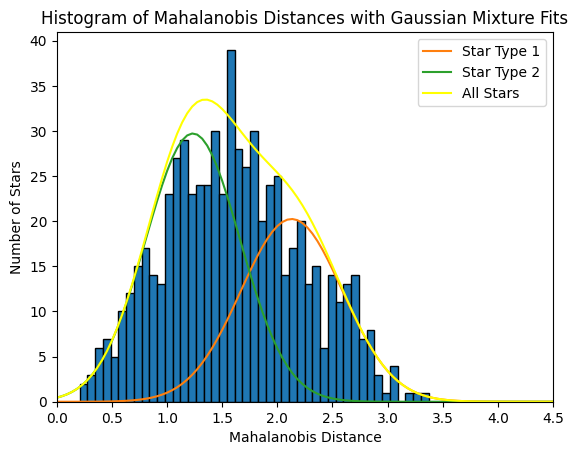

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Load the data
df = pd.read_csv('FM.csv')

# Extract Mahalanobis distances
mahalanobis_distances = df['Mahalanobis Distance']

# Define the range for the x-axis
xmin, xmax = (0, 4.5)
x = np.linspace(xmin, xmax, 100)

# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2)
gmm.fit(mahalanobis_distances.values.reshape(-1, 1))

# Plot the histogram
plt.hist(mahalanobis_distances, bins=45, edgecolor='black')

# Plot the GMM components
for i in range(2):
    pdf_component = gmm.weights_[i] * norm.pdf(x, loc=gmm.means_[i][0], scale=np.sqrt(gmm.covariances_[i][0]))
    plt.plot(x, pdf_component * len(mahalanobis_distances) / 12, label=f'Star Type {i+1}')

# Plot the combined GMM PDF
pdf_sum = gmm.weights_[0] * norm.pdf(x, loc=gmm.means_[0][0], scale=np.sqrt(gmm.covariances_[0][0])) + \
          gmm.weights_[1] * norm.pdf(x, loc=gmm.means_[1][0], scale=np.sqrt(gmm.covariances_[1][0]))
plt.plot(x, pdf_sum * len(mahalanobis_distances) /12, color='yellow', label='All Stars')

# Ensure the origin of the x and y axes coincide
plt.xlim(xmin, xmax)
plt.ylim(0, plt.ylim()[1])  # Set y-axis to start at 0

# Draw the x and y axis lines at the origin
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Add labels and title
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Stars')
plt.title('Histogram of Mahalanobis Distances with Gaussian Mixture Fits')
plt.legend()

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


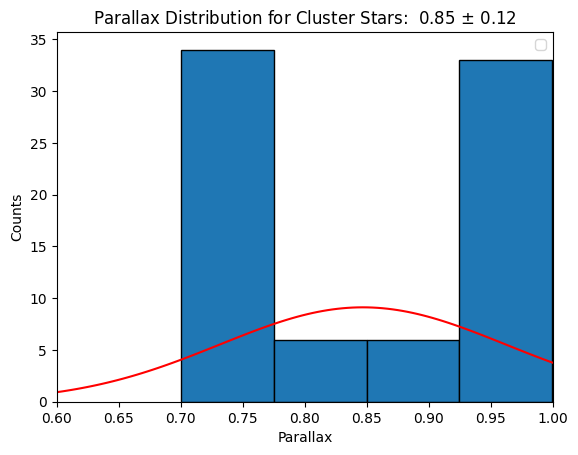

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


data = pd.read_csv('FM.csv')


cluster_stars = data[data['CM'] >= 0.5]


X = cluster_stars[['parallax']].values


gmm = GaussianMixture(n_components=1) 
gmm.fit(X)


xmin, xmax = plt.xlim(0.6,1)
x = np.linspace(xmin, xmax, 100)


pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))


plt.hist(X, bins=4, edgecolor='black', density=False)


plt.plot(x, pdf * len(X) /30, color='red')

plt.xlabel('Parallax')
plt.ylabel('Counts')


am = np.mean(X)
variance = np.var(X)


title = "Parallax Distribution for Cluster Stars:  {:.2f} $\pm$ {:.2f}".format(am, np.sqrt(variance))
plt.title(title)

plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


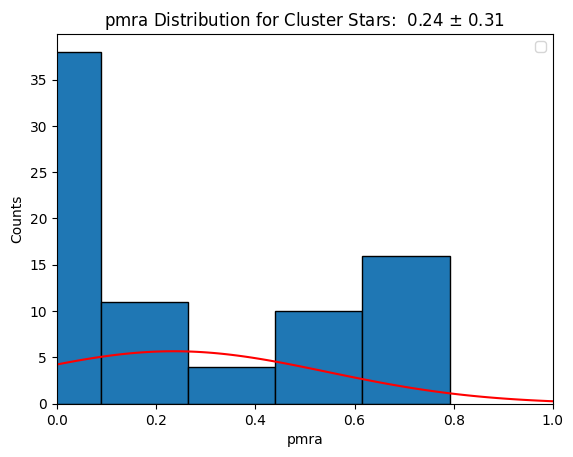

In [58]:
cluster_stars = data[data['CM'] >= 0.5]


X = cluster_stars[['pmra']].values


gmm = GaussianMixture(n_components=1) 
gmm.fit(X)


xmin, xmax = plt.xlim(0, 1)
x = np.linspace(xmin, xmax, 100)


pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))


plt.hist(X, bins=5, edgecolor='black', density=False)


plt.plot(x, pdf * len(X) /18, color='red')

plt.xlabel('pmra')
plt.ylabel('Counts')


am = np.mean(X)
variance = np.var(X)


title = "pmra Distribution for Cluster Stars:  {:.2f} $\pm$ {:.2f}".format(am, np.sqrt(variance))
plt.title(title)

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


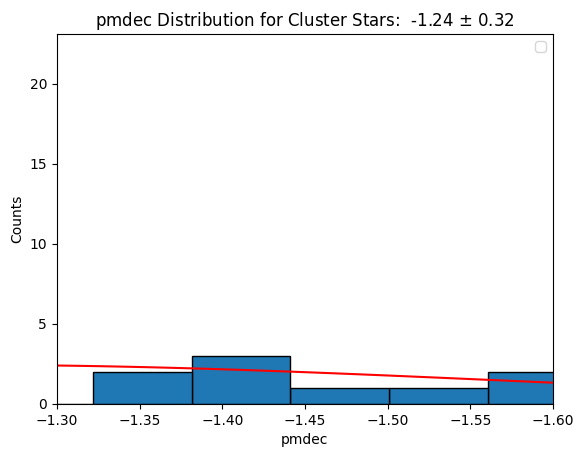

In [59]:
cluster_stars = data[data['CM'] >= 0.5]

X = cluster_stars[['pmdec']].values


gmm = GaussianMixture(n_components=1)  
gmm.fit(X)


xmin, xmax = plt.xlim(-1.3, -1.6)
x = np.linspace(xmin, xmax, 100)


pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))


plt.hist(X, bins=15, edgecolor='black', density=False)


plt.plot(x, pdf * len(X) /40, color='red')

plt.xlabel('pmdec')
plt.ylabel('Counts')


am = np.mean(X)
variance = np.var(X)


title = "pmdec Distribution for Cluster Stars:  {:.2f} $\pm$ {:.2f}".format(am, np.sqrt(variance))
plt.title(title)

plt.legend()
plt.show()

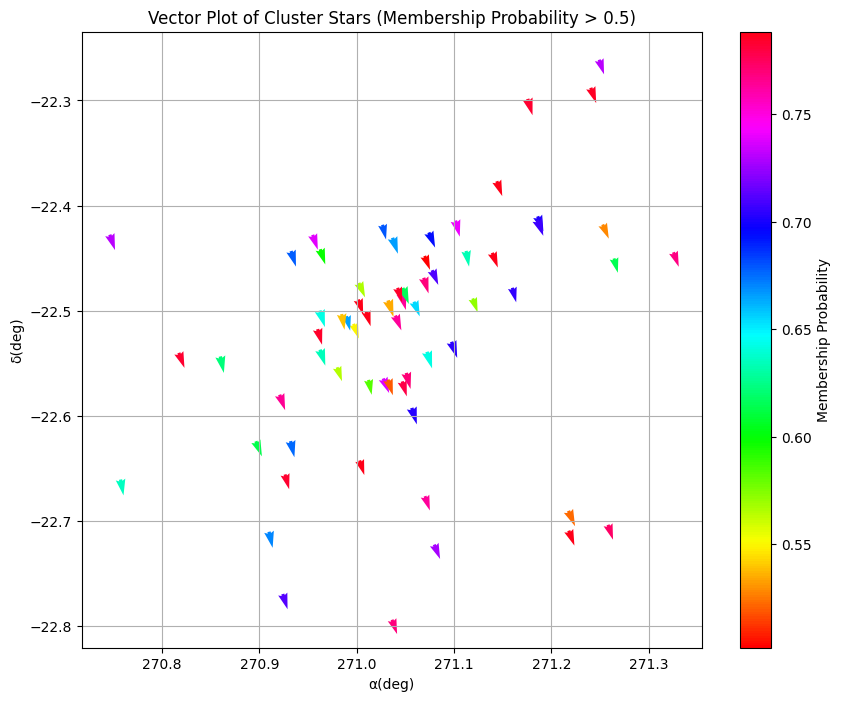

In [185]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('FM.csv')  


cluster_stars = data[data['CM'] > 0.5]


pmra_cluster = cluster_stars['pmra']
pmdec_cluster = cluster_stars['pmdec']
ra_cluster = cluster_stars['ra']
dec_cluster = cluster_stars['dec']
membership_prob = cluster_stars['CM']


plt.figure(figsize=(10, 8))
plt.quiver(ra_cluster, dec_cluster, pmra_cluster, pmdec_cluster, membership_prob, scale=60, cmap='hsv')
plt.xlabel('α(deg)')
plt.ylabel('δ(deg)')
plt.title('Vector Plot of Cluster Stars (Membership Probability > 0.5)')
plt.grid(True)


plt.colorbar(label='Membership Probability')

plt.show()


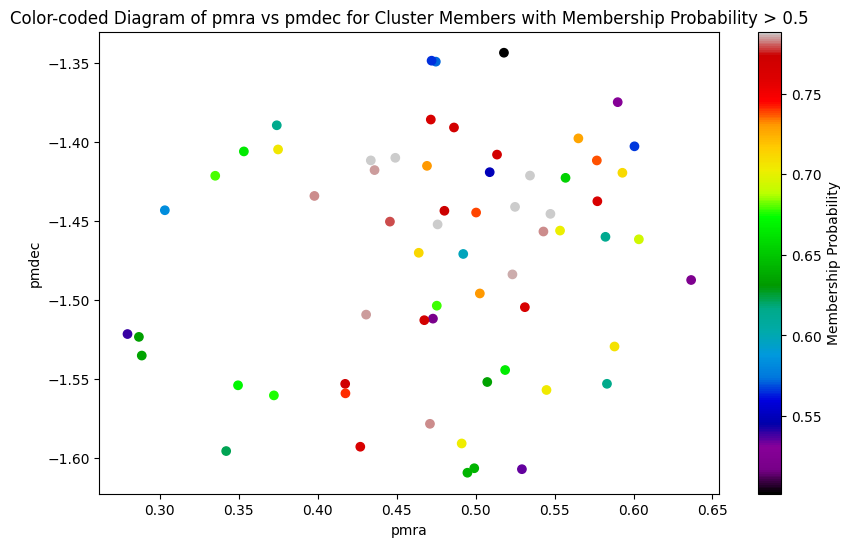

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv('FM.csv')


cluster_members = data[data['CM'] > 0.5]


plt.figure(figsize=(10, 6))
plt.scatter(cluster_members['pmra'], cluster_members['pmdec'], c=cluster_members['CM'], cmap='nipy_spectral')
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.title('Color-coded Diagram of pmra vs pmdec for Cluster Members with Membership Probability > 0.5')
plt.colorbar(label='Membership Probability')
plt.show()


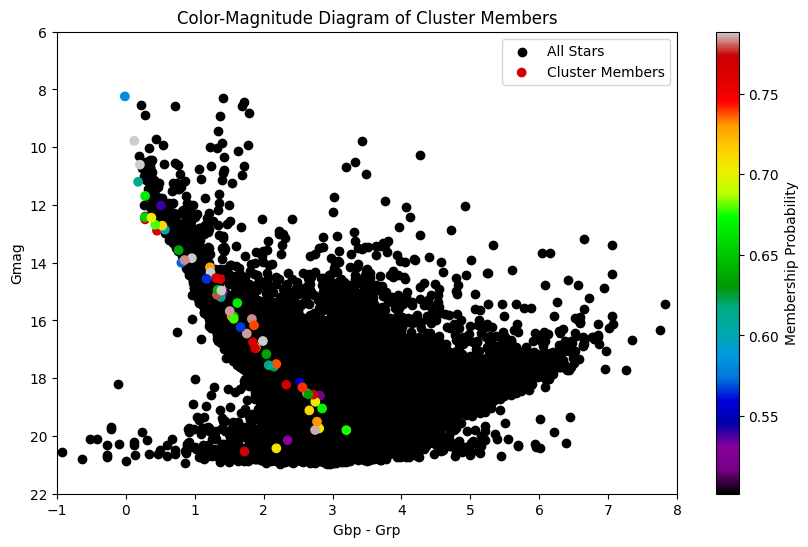

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv('FM.csv')
X = pd.read_csv(r'E:\dissertation\NGC6416\NGC6416(20).csv')

cluster_members = data[data['CM'] > 0.5]

# Plot color-magnitude diagram for all stars
plt.figure(figsize=(10, 6))
plt.scatter(X['phot_bp_mean_mag'] - X['phot_rp_mean_mag'], X['phot_g_mean_mag'], c='black', label='All Stars')


plt.scatter(cluster_members['phot_bp_mean_mag'] - cluster_members['phot_rp_mean_mag'], cluster_members['phot_g_mean_mag'], c=cluster_members['CM'], cmap='nipy_spectral', label='Cluster Members')
plt.colorbar(label='Membership Probability')

plt.xlabel('Gbp - Grp')
plt.ylabel('Gmag')
plt.ylim(22,6)
plt.xlim(-1,8)
plt.title('Color-Magnitude Diagram of Cluster Members')
plt.legend()
plt.show()
